# Training Ensemble on MNIST Dataset 
- On the function points branch of nengo
- On the vision branch of nengo_extras

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import nengo
import numpy as np
import scipy.ndimage
import matplotlib.animation as animation
from matplotlib import pylab
from PIL import Image
import nengo.spa as spa
import cPickle
import random

from nengo_extras.data import load_mnist
from nengo_extras.vision import Gabor, Mask


In [2]:
dim =28

Load the MNIST training and testing images

In [3]:
# --- load the data
img_rows, img_cols = 28, 28

(X_train, y_train), (X_test, y_test) = load_mnist()

X_train = 2 * X_train - 1  # normalize to -1 to 1
X_test = 2 * X_test - 1  # normalize to -1 to 1

In [4]:
X_train.shape

(60000L, 784L)

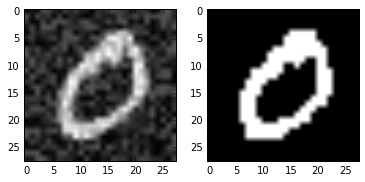

In [5]:
noise = np.random.random([dim,dim])
#noise = 2* noise - 1 # normalize to -1 to 1
noise = noise+np.reshape(X_train[1],(28,28))
plt.subplot(121)
plt.imshow(noise,cmap="gray")

low_pass = noise.copy()
low_pass[low_pass<0]=-1
low_pass[low_pass>0]=1

plt.subplot(122)
plt.imshow(low_pass,cmap="gray")

In [7]:
def intense(img):
    newImg = img.copy()
    newImg[newImg < 0] = -1
    newImg[newImg > 0] = 1
    return newImg



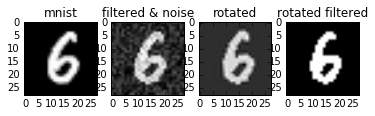

In [51]:
i=random.randint(1,100)
img = X_train[i]
img_filtered = intense(scipy.ndimage.gaussian_filter(img, sigma=1))
rotated = scipy.ndimage.rotate(img_filtered.reshape(dim,dim),6,reshape=False,cval=-1)
rotated_filtered = intense(scipy.ndimage.gaussian_filter(rotated, sigma=1))

a = np.random.random([dim,dim])
img_filtered = img_filtered+a.ravel()


plt.subplot(141)
plt.title("mnist")
plt.imshow(np.reshape(img,(dim,dim)),cmap="gray")
plt.subplot(142)
plt.title("filtered & noise")
plt.imshow(np.reshape(img_filtered,(dim,dim)),cmap="gray")
plt.subplot(143)
plt.title("rotated")
plt.imshow(np.reshape(rotated,(dim,dim)),cmap="gray")
plt.subplot(144)
plt.title("rotated filtered")
plt.imshow(np.reshape(rotated_filtered,(dim,dim)),cmap="gray")



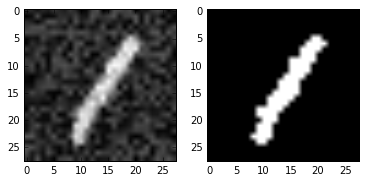

In [9]:
img = np.random.random([dim,dim])

img = img.ravel()
i=random.randint(1,100)
img = img+X_train[i]

plt.subplot(121)
plt.imshow(np.reshape(img,(dim,dim)),cmap="gray")
plt.subplot(122)
plt.imshow(np.reshape(intense(img),(dim,dim)),cmap="gray")

In [8]:
#Create set of noisy images
noise_train = np.random.random(X_train.shape)
noise_train = 2 * noise_train -1# normalize to -1 to 1
#Training with mnist
#noise_train = noise_train + X_train

In [9]:
#Clean up noisy images with intensifying
clean_train = intense(noise_train)

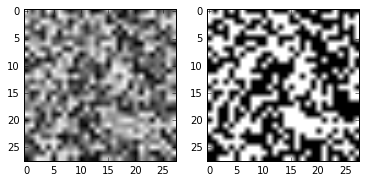

In [10]:
plt.subplot(121)
plt.imshow(np.reshape(noise_train[1],(dim,dim)),cmap="gray")
plt.subplot(122)
plt.imshow(np.reshape(clean_train[1],(dim,dim)),cmap="gray")

## The Network
- The network parameters must be the same here as when the weight matrices are used later on
- The network is made up of an ensemble and anodes
  - The first connection ( to v) computes the weights from the activities of the noise to the cleaned images

  
  

In [ ]:
rng = np.random.RandomState(9)

# --- set up network parameters
n_vis = noise_train.shape[1]
n_out =  noise_train.shape[1]
#number of neurons/dimensions of semantic pointer
n_hid = 1000 #Try with more neurons for more accuracy


#Want the encoding/decoding done on the training images
ens_params = dict(
    eval_points=X_train,
    neuron_type=nengo.LIF(), #Why not use LIF? originally used LIFRate()
    intercepts=nengo.dists.Choice([-0.5]),
    max_rates=nengo.dists.Choice([100]),
    )


#Least-squares solver with L2 regularization.
solver = nengo.solvers.LstsqL2(reg=0.01)
#solver = nengo.solvers.LstsqL2(reg=0.0001)


#network that generates the weight matrices between neuron activity and images and the labels
with nengo.Network(seed=3) as model:
    a = nengo.Ensemble(n_hid, n_vis, seed=3, **ens_params)
    v = nengo.Node(size_in=n_out)
    conn = nengo.Connection(
        a, v, synapse=None,
        eval_points=X_train, function=X_train,#Not used anymore
        solver=solver)
    

# linear filter used for edge detection as encoders, more plausible for human visual system
encoders = Gabor().generate(n_hid, (11, 11), rng=rng)
encoders = Mask((28, 28)).populate(encoders, rng=rng, flatten=True)
#Set the ensembles encoders to this
a.encoders = encoders

#Check the encoders were correctly made
plt.imshow(encoders[0].reshape(28, 28), vmin=encoders[0].min(), vmax=encoders[0].max(), cmap='gray')

## Evaluating the network statically
- Functions for computing representation of the image at different levels of encoding/decoding
- get_outs  returns the output of the network
- able to evaluate on many images
- no need to run the simulator

In [ ]:
#Get the one hot labels for the images
def get_outs(sim, images):
    #The activity of the neurons when an image is given as input
    _, acts = nengo.utils.ensemble.tuning_curves(a, sim, inputs=images)
    #The activity multiplied by the weight matrix (calculated in the network) to give the one-hot labels
    return np.dot(acts, sim.data[conn2].weights.T)

#Check how many of the labels were produced correctly
#def get_error(sim, images, labels):
#    return np.argmax(get_outs(sim, images), axis=1) != labels

#Get label of the images
#def get_labels(sim,images):
#    return np.argmax(get_outs(sim, images), axis=1)

#Get the neuron activity of an image or group of images (this is the semantic pointer in this case)
def get_activities(sim, images):
    _, acts = nengo.utils.ensemble.tuning_curves(a, sim, inputs=images)
    return acts

#Get the representation of the image after it has gone through the encoders (Gabor filters) but before it is in the neurons
#This must be computed to create the weight matrix for rotation from neuron activity to this step
# This allows a recurrent connection to be made from the neurons to themselves later
def get_encoder_outputs(sim,images):
    #Pass the images through the encoders
    outs = np.dot(images,sim.data[a].encoders.T) #before the neurons 
    return outs

## Simulator
- Calculate the neuron activities of each set of images
- Generate the weight matrices between original activities and clean activities


In [ ]:
with nengo.Simulator(model) as sim:    
    
    #Neuron activities 
    noise_acts = get_activities(sim,noise_train)
    clean = get_encoder_outputs(sim,clean_train)

    
    #solvers for a learning rule
    solver_low_pass = nengo.solvers.LstsqL2(reg=1e-8)

    
    
    #find weight matrix between neuron activity of the original image and the clean img
    #weights returns a tuple including information about learning process, just want the weight matrix
    weights,_ = solver_low_pass(noise_acts, clean)
    


# Saving weight matrices


In [ ]:
filename = "low_pass_weights_mnist" + str(n_hid) +".p"
cPickle.dump(weights, open( filename, "wb" ) )